# Layer-wise Analysis

This notebook reproduces the layer analysis figures:
- **Fig 2 bottom**: Layer-wise similarity curves showing matching vs non-matching pair similarity across 24 layers
- **Fig S7**: Full layer-wise accuracy: encoder (DINOv2) + L0-L23 + confidence

**Prerequisites**: Run `python scripts/run_evaluation.py --gpu_id <GPU>` first to generate the CSVs.

In [1]:
import sys
sys.path.insert(0, "..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from human_multiview.config import RESULTS_DIR, N_LAYERS
from human_multiview.plotting import COLORS, set_paper_style

set_paper_style()

## Load data

In [2]:
df_layers = pd.read_csv(RESULTS_DIR / "vggt_layer_analysis.csv")
df_dino = pd.read_csv(RESULTS_DIR / "dinov2_similarity.csv")
df_conf = pd.read_csv(RESULTS_DIR / "all_models_confidence.csv")

print(f"Layer analysis: {len(df_layers)} trials")
print(f"DINOv2: {len(df_dino)} trials")
print(f"Confidence: {len(df_conf)} trials")

Layer analysis: 1530 trials
DINOv2: 1555 trials
Confidence: 1555 trials


## Fig S7: Full layer-wise accuracy

Shows accuracy at each layer for three similarity metrics (mean, max, global_pool),
with encoder (DINOv2) on the left and confidence on the right.

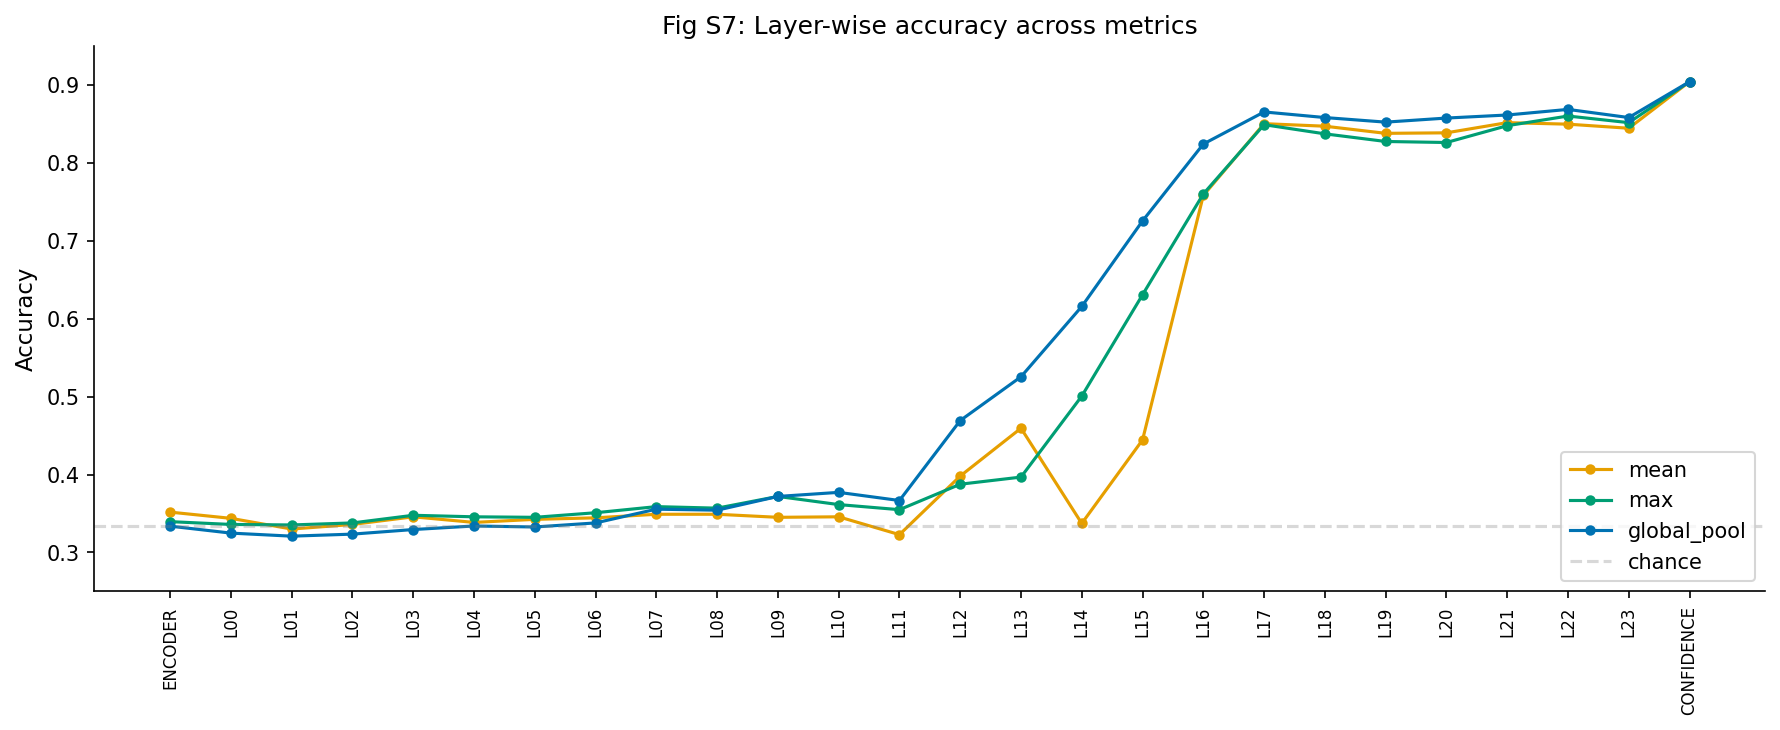

In [3]:
metrics = ["mean", "max", "global_pool"]
metric_colors = {"mean": "#E69F00", "max": "#009E73", "global_pool": "#0072B2"}

fig, ax = plt.subplots(figsize=(12, 5))

# Compute per-layer accuracy for each metric
for metric in metrics:
    layer_accs = []

    # DINOv2 encoder accuracy
    dino_col = f"dinov2_{metric}"
    if dino_col in df_dino.columns:
        encoder_acc = df_dino[dino_col].mean()
    else:
        encoder_acc = np.nan
    layer_accs.append(encoder_acc)

    # Layers 0-23
    for layer_idx in range(N_LAYERS):
        col = f"vggt_L{layer_idx}_{metric}"
        if col in df_layers.columns:
            layer_accs.append(df_layers[col].mean())
        else:
            layer_accs.append(np.nan)

    # Confidence-based accuracy
    conf_col = f"vggt_mean_masked_correct"
    if conf_col in df_conf.columns:
        conf_acc = df_conf[conf_col].mean()
    else:
        conf_acc = np.nan
    layer_accs.append(conf_acc)

    x_positions = list(range(len(layer_accs)))
    ax.plot(x_positions, layer_accs, "o-", color=metric_colors[metric],
            label=metric, markersize=4, linewidth=1.5)

# X-axis labels
x_labels = ["ENCODER"] + [f"L{i:02d}" for i in range(N_LAYERS)] + ["CONFIDENCE"]
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=90, fontsize=8)

ax.axhline(y=1/3, color="gray", linestyle="--", alpha=0.3, label="chance")
ax.set_ylabel("Accuracy")
ax.set_ylim(0.25, 0.95)
ax.legend(loc="lower right")
ax.set_title("Fig S7: Layer-wise accuracy across metrics")
plt.tight_layout()
plt.savefig(RESULTS_DIR / "fig_s7_layer_accuracy.pdf")
plt.show()

## Fig 2 bottom: Layer-wise similarity curves

For a representative set of trials, show how pairwise similarity evolves across layers
for matching (AA') vs non-matching (AB, BA') pairs.

In [4]:
# This figure requires per-pair similarity values across layers.
# Since run_evaluation.py stores per-layer correctness (binary), we need to
# re-compute similarity values for visualization. This cell runs VGGT on a
# few example trials to generate the similarity curves.

import torch
from human_multiview.data import load_mochi, get_trial_images
from human_multiview.models import get_model
from human_multiview.evaluate import compute_similarity

# Pick a representative trial
dataset = load_mochi()

# Find a trial where the solution layer is in the middle range
mid_layer_trials = df_layers.dropna(subset=["earliest_reliable_layer_mean"])
mid_layer_trials = mid_layer_trials[
    (mid_layer_trials["earliest_reliable_layer_mean"] >= 8) &
    (mid_layer_trials["earliest_reliable_layer_mean"] <= 16)
]
example_trial_name = mid_layer_trials.iloc[0]["trial_name"] if len(mid_layer_trials) > 0 else df_layers.iloc[0]["trial_name"]

# Find the trial index
trial_idx = None
for i in range(len(dataset)):
    if dataset[i]["trial"] == example_trial_name:
        trial_idx = i
        break

print(f"Example trial: {example_trial_name} (index {trial_idx})")

if trial_idx is not None:
    trial = dataset[trial_idx]
    img_A, img_Ap, img_B, info = get_trial_images(trial)
    print(f"Dataset: {info['dataset']}, Oddity: {info['oddity_index']}")

Example trial: familiar_high_screen03 (index 2)
Dataset: barense, Oddity: 2


In [5]:
# Load VGGT and compute per-layer similarities
device = "cuda" if torch.cuda.is_available() else "cpu"
ModelClass = get_model("vggt")
vggt = ModelClass()
vggt.load(device)

# Extract features for all three pairs
pairs = {
    "AA'": (img_A, img_Ap),
    "AB": (img_A, img_B),
    "BA'": (img_B, img_Ap),
}

pair_similarities = {}
for pair_name, (im1, im2) in pairs.items():
    agg_tokens, psi = vggt.extract_layer_features(im1, im2)
    sims = {metric: [] for metric in ["mean", "max", "global_pool"]}
    for layer_idx in range(N_LAYERS):
        t1 = vggt.extract_patch_tokens_at_layer(agg_tokens, layer_idx, psi, 0)
        t2 = vggt.extract_patch_tokens_at_layer(agg_tokens, layer_idx, psi, 1)
        for metric in sims:
            sims[metric].append(compute_similarity(t1, t2, metric))
    pair_similarities[pair_name] = sims
    del agg_tokens

vggt.unload()
print("Layer features extracted.")

Layer features extracted.


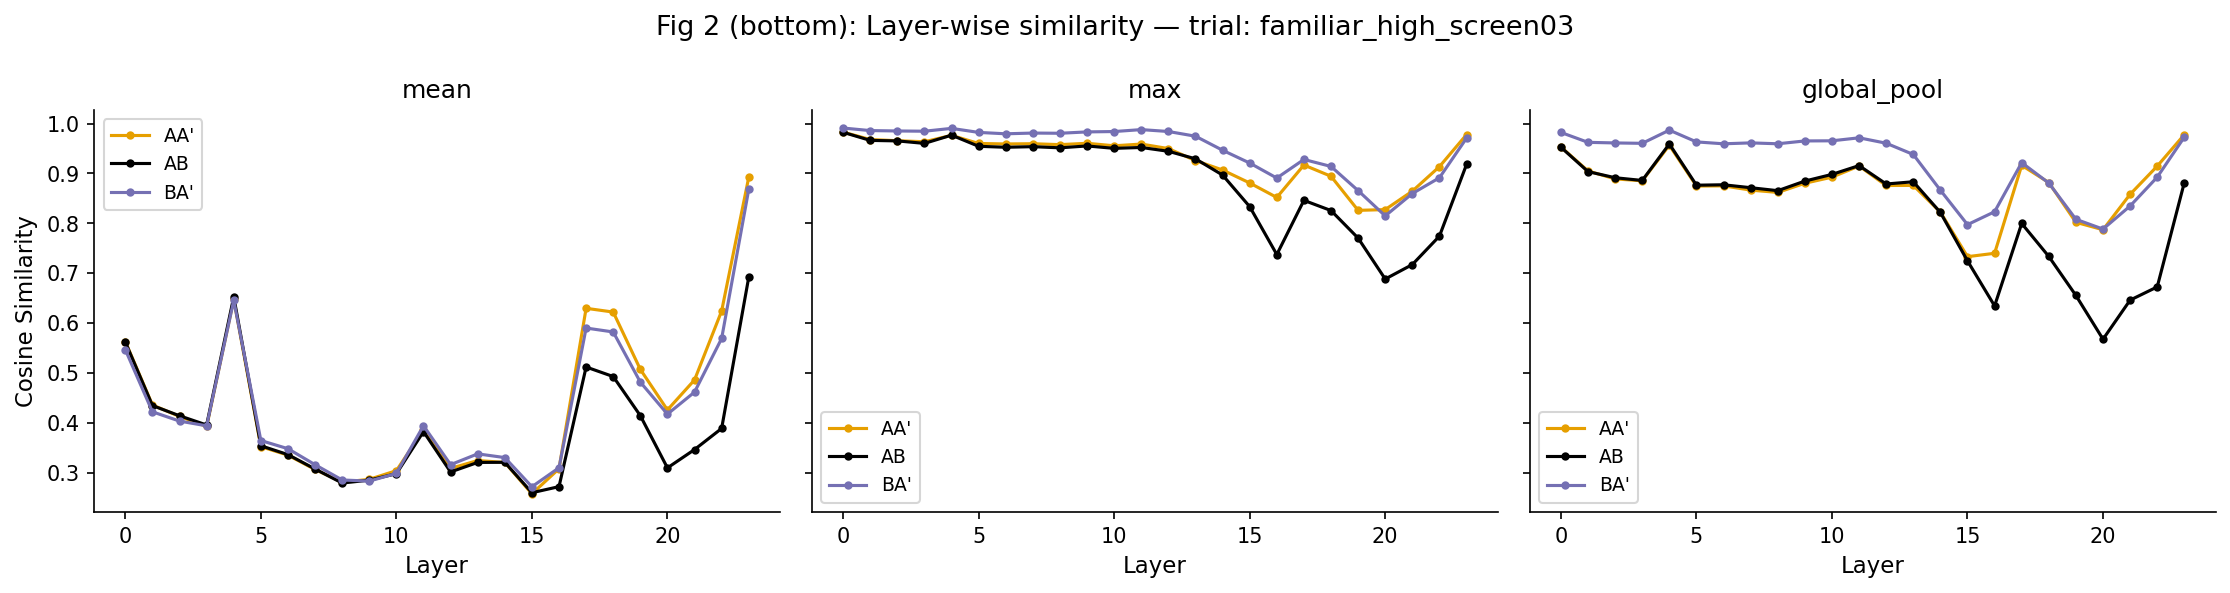

In [6]:
# Plot layer-wise similarity curves
pair_colors = {
    "AA'": COLORS["match"],
    "AB": COLORS["nonmatch_ab"],
    "BA'": COLORS["nonmatch_bp"],
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for ax, metric in zip(axes, ["mean", "max", "global_pool"]):
    for pair_name in ["AA'", "AB", "BA'"]:
        sims = pair_similarities[pair_name][metric]
        ax.plot(range(N_LAYERS), sims, "o-", color=pair_colors[pair_name],
                label=pair_name, markersize=3, linewidth=1.5)
    ax.set_xlabel("Layer")
    ax.set_title(metric)
    ax.legend(fontsize=9)

axes[0].set_ylabel("Cosine Similarity")
fig.suptitle(f"Fig 2 (bottom): Layer-wise similarity — trial: {example_trial_name}", fontsize=13)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "fig2_bottom_layer_similarity.pdf")
plt.show()